In [ ]:
# !pip install pandas
# !pip install numpy
# !pip install matplotlib
# !pip install keras
# !pip install sklearn
# !pip install tensorflow
!pip install refinitiv-dataplatform==1.0.0a7.post7 jupyterlab

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams

rcParams['figure.figsize']=20,10
import keras
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from sklearn.preprocessing import MinMaxScaler

df=pd.read_csv("shows.csv")

In [2]:
df.head()

TimeStart  OpenValue  MaxValue  MinValue  CloseValue    Unknow1  \
0  1654906500000   29178.29  29228.70  29139.89    29190.63  437.15078   
1  1654907400000   29190.63  29248.42  29175.04    29226.16  372.60730   
2  1654908300000   29226.17  29248.19  29213.89    29233.79  155.65128   
3  1654909200000   29233.79  29259.34  29196.13    29217.25  268.40950   
4  1654910100000   29217.24  29228.48  29181.72    29223.12  227.12295   

         TimeEnd       Unknow2  Unknow3    Unknow4       Unknow5  Unknow6  
0  1654907399999  1.275512e+07     7364  278.77409  8.133149e+06        0  
1  1654908299999  1.088735e+07     7667  196.45568  5.740084e+06        0  
2  1654909199999  4.550541e+06     5054   80.23296  2.345596e+06        0  
3  1654910099999  7.846387e+06     6974  118.76175  3.471935e+06        0  
4  1654910999999  6.635164e+06     5382  110.33749  3.223367e+06        0

## Analyze the closing prices from dataframe

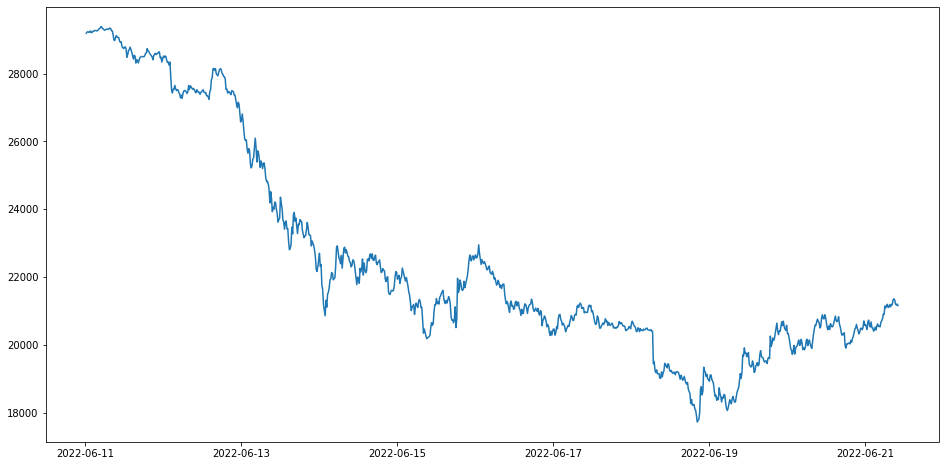

In [4]:
df["TimeStart"]=pd.to_datetime(df.TimeStart, unit='ms')
df.index=df['TimeStart']
plt.figure(figsize=(16,8))
plt.plot(df["CloseValue"],label='Close Price history')

## Sort the dataset on date time and filter “Date” and “Close” columns:

### Normalize the new filtered dataset

In [ ]:
data=df.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['TimeStart','PoC'])

for i in range(1,len(data)):
    new_daftaset["TimeStart"][i]=data['TimeStart'][i]
    new_dataset["PoC"][i] = (df["CloseValue"][i] / df["CloseValue"][i-1] - 1) * 100

scaler=MinMaxScaler(feature_range=(0,1))
new_dataset.index=new_dataset.TimeStart
new_dataset.drop("TimeStart",axis=1,inplace=True)
final_dataset=new_dataset.values

# split
train_data=final_dataset[1:990,:]
valid_data=final_dataset[990:,:]


scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(final_dataset)
x_train_data,y_train_data=[],[]
for i in range(61, len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])
    
x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)
print(x_train_data, y_train_data )
x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

In [ ]:
lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))

lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train_data,y_train_data,epochs=5,batch_size=1,verbose=2)

In [ ]:
new_dataset[len(new_dataset)-100-60:]

In [ ]:
len(valid_data)

In [ ]:
X_test=[]
data_test = []
data_test1 = new_dataset[len(new_dataset)-100-60:].values
i = 0
data_test2 = data_test1
while (i<100+15):
    inputs_data1=data_test2
    inputs_data1=scaler.fit_transform(inputs_data1)
    data_test.append(inputs_data1[i: 60 +i,0])
    X_test=np.array(data_test)
    X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
    predicted_closing_price=lstm_model.predict(X_test)
    predicted_closing_price=scaler.inverse_transform(predicted_closing_price)
    i = i + 1    
    data_test2 = np.concatenate((data_test1, np.array(predicted_closing_price).reshape((i,1))))


In [ ]:
# print(predicted_closing_price)
import datetime
train_data=new_dataset[:990]
next_time_frame = []
show_data = pd.DataFrame(index=range(0,len(df)),columns=['TimeStart','PoC'])
# new_dataset.insert("TimeStart",axis=1,inplace=True)
print(data["TimeStart"][len(data)-100].timestamp())
next_time = data["TimeStart"][len(data)-100].timestamp() * 1000
for x in predicted_closing_price:
    next_time += 15*60*1000
    next_time_frame.append(next_time);
valid_data = pd.DataFrame({
       "TimeStart": next_time_frame,
        "Predictions": predicted_closing_price.reshape((len(predicted_closing_price),))
    }
)
df.index=df['TimeStart']
valid_data['TimeStart'] = pd.to_datetime(valid_data.TimeStart, unit='ms')
valid_data.index = valid_data['TimeStart']
plt.plot(df["PoC"])
plt.plot(valid_data["Predictions"])

Build the dashboard using Plotly dash

In [ ]:
!pip3 install dash
!pip3 install dash-html-components
!pip3 install dash-core-components